# Susceptibility to substitution

## 1 Setup

Flags and settings.

In [1]:
SAVE_FIGURES = False
PAPER_FEATURES = ['frequency', 'aoa', 'clustering', 'letters_count',
                  'synonyms_count', 'orthographic_density']
BIN_COUNT = 4

Imports and database setup.

In [2]:
import pandas as pd
import seaborn as sb
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from progressbar import ProgressBar
from statsmodels.stats.proportion import multinomial_proportions_confint

%cd -q ..
from brainscopypaste.conf import settings
%cd -q notebooks
from brainscopypaste.mine import Model, Time, Source, Past, Durl
from brainscopypaste.db import Substitution
from brainscopypaste.utils import init_db, session_scope, stopwords
engine = init_db()

Build our data.

In [3]:
def qposition(values, position):
    value = values[position]
    if np.isnan(value):
        return np.nan, np.nan
    finite_values = values[np.isfinite(values)]
    svalues = np.array(sorted(finite_values))
    length = len(svalues)
    ours = np.where(svalues == value)[0]
    return ours[0] / length, (ours[-1] + 1) / length

In [4]:
model = Model(time=Time.discrete, source=Source.all, past=Past.all, durl=Durl.exclude_past, max_distance=1)
stop_poses = ['C', 'F', 'I', 'M', 'P', 'S', 'U']

data = []

# First get the exact substitution ids so we can get a working progress bar
# in the next step.
with session_scope() as session:
    substitutions = session.query(Substitution.id)\
        .filter(Substitution.model == model)
    print("Got {} substitutions for model {}"
          .format(substitutions.count(), model))
    substitution_ids = [id for (id,) in substitutions]

for substitution_id in ProgressBar(term_width=80)(substitution_ids):
    with session_scope() as session:
        substitution = session.query(Substitution).get(substitution_id)
        
        # Prepare these arrays for use in stopword-checking.
        dslice = slice(substitution.start,
                       substitution.start
                       + len(substitution.destination.tokens))
        lemmas = substitution.source.lemmas[dslice]
        tokens = substitution.source.tokens[dslice]
        tags = substitution.source.tags[dslice]
        is_stopword = np.array([(lemma in stopwords)
                                or (token in stopwords)
                                for (lemma, token) in zip(lemmas, tokens)])
        
        for feature in Substitution.__features__:
            
            # Get feature values for the sentence and its words.
            sentence_values, _ = substitution.\
                source_destination_features(feature)
            sentence_values_rel, _ = substitution.\
                source_destination_features(feature,
                                            sentence_relative='median')
            source_type, _ = Substitution.__features__[feature]
            words = getattr(substitution.source, source_type)[dslice]
            
            # Find the bins we'll use.
            # If there are only NaNs or only one feature value
            # we can't get bins on this sentence, so we want at least
            # 2 different feature values.
            # We also skip feature values if the source word is not coded
            # for the feature, as it would skew the 'appeared' 
            # distributions compared to the distribution of substituted
            # words. (For instance, the sum of categories would not be 
            # equal to the sum of H0s in the very last graphs, 
            # on sentencequantile. It also lets us make meaningful H0
            # comparison in all the other feature-based graphs.)
            non_sw_values = sentence_values.copy()
            non_sw_values[is_stopword] = np.nan
            non_sw_value_set = \
                set(non_sw_values[np.isfinite(non_sw_values)])
            if (len(non_sw_value_set) <= 1 or
                    np.isnan(sentence_values[substitution.position])):
                allnans = [np.nan] * len(non_sw_values)
                bins = allnans
                non_sw_values = allnans
                sentence_values = allnans
                sentence_values_rel = allnans
            else:
                bins = pd.cut(non_sw_values, BIN_COUNT, labels=False)
            
            # For each non-stopword, store its various properties.
            for i, (word, tag, skip) in enumerate(zip(words, tags,
                                                      is_stopword)):
                if skip:
                    # Drop any stopwords.
                    continue

                # Get a readable POS tag
                rtag = tag[0]
                rtag = 'Stopword-like' if rtag in stop_poses else rtag
                
                # Get the word's quantile position.
                start_quantile, stop_quantile = qposition(non_sw_values, i)

                # Store the word's properties.
                data.append({
                    'cluster_id': substitution.source.cluster.sid,
                    'destination_id': substitution.destination.sid,
                    'occurrence': substitution.occurrence,
                    'source_id': substitution.source.sid,
                    'position': substitution.position,
                    'feature': feature,
                    'word': word,
                    'POS': tag,
                    'rPOS': rtag,
                    'target': i == substitution.position,
                    'value': sentence_values[i],
                    'value_rel': sentence_values_rel[i],
                    'bin': bins[i],
                    'start_quantile': start_quantile,
                    'stop_quantile': stop_quantile,
                    'word_position': i
                })

words = pd.DataFrame(data)
del data

Got 15119 substitutions for model Model(time=Time.discrete, source=Source.all, past=Past.all, durl=Durl.exclude_past, max_distance=1)


  0% (    1 of 15119) |                   | Elapsed Time: 0:00:04 ETA:  20:17:57

  0% (   37 of 15119) |                    | Elapsed Time: 0:00:05 ETA:  0:07:25

  0% (   88 of 15119) |                    | Elapsed Time: 0:00:06 ETA:  0:05:54

  1% (  172 of 15119) |                    | Elapsed Time: 0:00:07 ETA:  0:04:24

  1% (  189 of 15119) |                    | Elapsed Time: 0:00:08 ETA:  0:04:26

  1% (  203 of 15119) |                    | Elapsed Time: 0:00:09 ETA:  0:05:24

  1% (  245 of 15119) |                    | Elapsed Time: 0:00:10 ETA:  0:05:31

  1% (  287 of 15119) |                    | Elapsed Time: 0:00:11 ETA:  0:05:45

  2% (  331 of 15119) |                    | Elapsed Time: 0:00:12 ETA:  0:05:42

  2% (  366 of 15119) |                    | Elapsed Time: 0:00:13 ETA:  0:05:49

  2% (  378 of 15119) |                    | Elapsed Time: 0:00:13 ETA:  0:05:35

  2% (  437 of 15119) |                    | Elapsed Time: 0:00:14 ETA:  0:05:26

  3% (  505 of 15119) |                    | Elapsed Time: 0:00:15 ETA:  0:05:43

  3% (  567 of 15119) |                    | Elapsed Time: 0:00:16 ETA:  0:05:18

  4% (  644 of 15119) |                    | Elapsed Time: 0:00:17 ETA:  0:04:28

  4% (  735 of 15119) |                    | Elapsed Time: 0:00:18 ETA:  0:03:57

  5% (  756 of 15119) |#                   | Elapsed Time: 0:00:18 ETA:  0:03:36

  5% (  849 of 15119) |#                   | Elapsed Time: 0:00:19 ETA:  0:03:13

  6% (  945 of 15119) |#                   | Elapsed Time: 0:00:20 ETA:  0:02:49

  6% ( 1037 of 15119) |#                   | Elapsed Time: 0:00:21 ETA:  0:02:38

  7% ( 1134 of 15119) |#                   | Elapsed Time: 0:00:23 ETA:  0:02:29

  8% ( 1215 of 15119) |#                   | Elapsed Time: 0:00:24 ETA:  0:02:27

  8% ( 1295 of 15119) |#                   | Elapsed Time: 0:00:25 ETA:  0:02:29

  8% ( 1323 of 15119) |#                   | Elapsed Time: 0:00:25 ETA:  0:02:30

  9% ( 1402 of 15119) |#                   | Elapsed Time: 0:00:26 ETA:  0:02:34

  9% ( 1482 of 15119) |#                   | Elapsed Time: 0:00:27 ETA:  0:02:36

 10% ( 1512 of 15119) |##                  | Elapsed Time: 0:00:27 ETA:  0:02:37

 10% ( 1592 of 15119) |##                  | Elapsed Time: 0:00:28 ETA:  0:02:40

 11% ( 1670 of 15119) |##                  | Elapsed Time: 0:00:29 ETA:  0:02:41

 11% ( 1701 of 15119) |##                  | Elapsed Time: 0:00:30 ETA:  0:02:40

 11% ( 1752 of 15119) |##                  | Elapsed Time: 0:00:31 ETA:  0:02:50

 12% ( 1818 of 15119) |##                  | Elapsed Time: 0:00:32 ETA:  0:02:55

 12% ( 1890 of 15119) |##                  | Elapsed Time: 0:00:33 ETA:  0:02:50

 13% ( 1976 of 15119) |##                  | Elapsed Time: 0:00:34 ETA:  0:02:46

 13% ( 2037 of 15119) |##                  | Elapsed Time: 0:00:35 ETA:  0:02:52

 13% ( 2079 of 15119) |##                  | Elapsed Time: 0:00:35 ETA:  0:02:51

 14% ( 2160 of 15119) |##                  | Elapsed Time: 0:00:36 ETA:  0:02:49

 14% ( 2238 of 15119) |##                  | Elapsed Time: 0:00:37 ETA:  0:02:48

 15% ( 2268 of 15119) |###                 | Elapsed Time: 0:00:38 ETA:  0:02:48

 15% ( 2345 of 15119) |###                 | Elapsed Time: 0:00:39 ETA:  0:02:37

 15% ( 2392 of 15119) |###                 | Elapsed Time: 0:00:40 ETA:  0:02:43

 16% ( 2457 of 15119) |###                 | Elapsed Time: 0:00:41 ETA:  0:02:59

 16% ( 2543 of 15119) |###                 | Elapsed Time: 0:00:42 ETA:  0:02:46

 17% ( 2646 of 15119) |###                 | Elapsed Time: 0:00:43 ETA:  0:02:44

 17% ( 2706 of 15119) |###                 | Elapsed Time: 0:00:44 ETA:  0:02:51

 18% ( 2765 of 15119) |###                 | Elapsed Time: 0:00:45 ETA:  0:02:57

 18% ( 2835 of 15119) |###                 | Elapsed Time: 0:00:46 ETA:  0:02:55

 19% ( 2927 of 15119) |###                 | Elapsed Time: 0:00:47 ETA:  0:02:35

 19% ( 2994 of 15119) |###                 | Elapsed Time: 0:00:48 ETA:  0:02:31

 20% ( 3024 of 15119) |####                | Elapsed Time: 0:00:48 ETA:  0:02:40

 20% ( 3084 of 15119) |####                | Elapsed Time: 0:00:50 ETA:  0:02:50

 20% ( 3169 of 15119) |####                | Elapsed Time: 0:00:51 ETA:  0:02:49

 21% ( 3213 of 15119) |####                | Elapsed Time: 0:00:51 ETA:  0:02:49

 21% ( 3280 of 15119) |####                | Elapsed Time: 0:00:52 ETA:  0:02:45

 22% ( 3359 of 15119) |####                | Elapsed Time: 0:00:53 ETA:  0:02:37

 22% ( 3402 of 15119) |####                | Elapsed Time: 0:00:54 ETA:  0:02:37

 23% ( 3485 of 15119) |####                | Elapsed Time: 0:00:55 ETA:  0:02:39

 23% ( 3567 of 15119) |####                | Elapsed Time: 0:00:56 ETA:  0:02:33

 23% ( 3591 of 15119) |####                | Elapsed Time: 0:00:56 ETA:  0:02:29

 24% ( 3682 of 15119) |####                | Elapsed Time: 0:00:57 ETA:  0:02:18

 24% ( 3757 of 15119) |####                | Elapsed Time: 0:00:58 ETA:  0:02:20

 25% ( 3780 of 15119) |#####               | Elapsed Time: 0:00:59 ETA:  0:02:18

 25% ( 3818 of 15119) |#####               | Elapsed Time: 0:01:00 ETA:  0:02:27

 25% ( 3893 of 15119) |#####               | Elapsed Time: 0:01:01 ETA:  0:02:28

 26% ( 3969 of 15119) |#####               | Elapsed Time: 0:01:02 ETA:  0:02:36

 26% ( 4031 of 15119) |#####               | Elapsed Time: 0:01:03 ETA:  0:02:48

 27% ( 4090 of 15119) |#####               | Elapsed Time: 0:01:04 ETA:  0:02:43

 27% ( 4158 of 15119) |#####               | Elapsed Time: 0:01:05 ETA:  0:03:02

 27% ( 4224 of 15119) |#####               | Elapsed Time: 0:01:06 ETA:  0:03:02

 28% ( 4294 of 15119) |#####               | Elapsed Time: 0:01:07 ETA:  0:02:44

 28% ( 4347 of 15119) |#####               | Elapsed Time: 0:01:08 ETA:  0:02:51

 29% ( 4420 of 15119) |#####               | Elapsed Time: 0:01:09 ETA:  0:02:47

 29% ( 4497 of 15119) |#####               | Elapsed Time: 0:01:10 ETA:  0:02:41

 30% ( 4536 of 15119) |######              | Elapsed Time: 0:01:10 ETA:  0:02:31

 30% ( 4597 of 15119) |######              | Elapsed Time: 0:01:11 ETA:  0:02:30

 31% ( 4692 of 15119) |######              | Elapsed Time: 0:01:12 ETA:  0:02:17

 31% ( 4725 of 15119) |######              | Elapsed Time: 0:01:13 ETA:  0:02:23

 31% ( 4816 of 15119) |######              | Elapsed Time: 0:01:14 ETA:  0:02:13

 32% ( 4914 of 15119) |######              | Elapsed Time: 0:01:15 ETA:  0:02:01

 33% ( 5000 of 15119) |######              | Elapsed Time: 0:01:16 ETA:  0:01:55

 33% ( 5064 of 15119) |######              | Elapsed Time: 0:01:17 ETA:  0:01:59

 33% ( 5103 of 15119) |######              | Elapsed Time: 0:01:18 ETA:  0:02:02

 34% ( 5178 of 15119) |######              | Elapsed Time: 0:01:19 ETA:  0:01:54

 34% ( 5274 of 15119) |######              | Elapsed Time: 0:01:20 ETA:  0:01:52

 35% ( 5292 of 15119) |#######             | Elapsed Time: 0:01:20 ETA:  0:01:46

 35% ( 5374 of 15119) |#######             | Elapsed Time: 0:01:21 ETA:  0:01:48

 36% ( 5459 of 15119) |#######             | Elapsed Time: 0:01:22 ETA:  0:01:49

 36% ( 5481 of 15119) |#######             | Elapsed Time: 0:01:22 ETA:  0:01:47

 36% ( 5550 of 15119) |#######             | Elapsed Time: 0:01:23 ETA:  0:01:52

 37% ( 5614 of 15119) |#######             | Elapsed Time: 0:01:24 ETA:  0:01:51

 37% ( 5670 of 15119) |#######             | Elapsed Time: 0:01:25 ETA:  0:01:47

 38% ( 5763 of 15119) |#######             | Elapsed Time: 0:01:26 ETA:  0:01:40

 38% ( 5859 of 15119) |#######             | Elapsed Time: 0:01:27 ETA:  0:01:38

 39% ( 5942 of 15119) |#######             | Elapsed Time: 0:01:28 ETA:  0:01:37

 40% ( 6048 of 15119) |########            | Elapsed Time: 0:01:29 ETA:  0:01:30

 40% ( 6129 of 15119) |########            | Elapsed Time: 0:01:30 ETA:  0:01:33

 41% ( 6237 of 15119) |########            | Elapsed Time: 0:01:31 ETA:  0:01:21

 41% ( 6329 of 15119) |########            | Elapsed Time: 0:01:32 ETA:  0:01:21

 42% ( 6426 of 15119) |########            | Elapsed Time: 0:01:34 ETA:  0:01:22

 43% ( 6512 of 15119) |########            | Elapsed Time: 0:01:35 ETA:  0:01:21

 43% ( 6615 of 15119) |########            | Elapsed Time: 0:01:36 ETA:  0:01:20

 44% ( 6690 of 15119) |########            | Elapsed Time: 0:01:37 ETA:  0:01:13

 44% ( 6772 of 15119) |########            | Elapsed Time: 0:01:38 ETA:  0:01:16

 45% ( 6804 of 15119) |#########           | Elapsed Time: 0:01:38 ETA:  0:01:16

 45% ( 6897 of 15119) |#########           | Elapsed Time: 0:01:39 ETA:  0:01:16

 46% ( 6993 of 15119) |#########           | Elapsed Time: 0:01:40 ETA:  0:01:13

 46% ( 7085 of 15119) |#########           | Elapsed Time: 0:01:41 ETA:  0:01:10

 47% ( 7155 of 15119) |#########           | Elapsed Time: 0:01:42 ETA:  0:01:19

 47% ( 7182 of 15119) |#########           | Elapsed Time: 0:01:43 ETA:  0:01:20

 48% ( 7260 of 15119) |#########           | Elapsed Time: 0:01:44 ETA:  0:01:18

 48% ( 7347 of 15119) |#########           | Elapsed Time: 0:01:45 ETA:  0:01:15

 48% ( 7371 of 15119) |#########           | Elapsed Time: 0:01:45 ETA:  0:01:16

 49% ( 7461 of 15119) |#########           | Elapsed Time: 0:01:46 ETA:  0:01:15

 50% ( 7560 of 15119) |##########          | Elapsed Time: 0:01:47 ETA:  0:01:15

 50% ( 7637 of 15119) |##########          | Elapsed Time: 0:01:48 ETA:  0:01:19

 50% ( 7707 of 15119) |##########          | Elapsed Time: 0:01:49 ETA:  0:01:17

 51% ( 7749 of 15119) |##########          | Elapsed Time: 0:01:49 ETA:  0:01:14

 51% ( 7829 of 15119) |##########          | Elapsed Time: 0:01:50 ETA:  0:01:13

 52% ( 7898 of 15119) |##########          | Elapsed Time: 0:01:51 ETA:  0:01:17

 52% ( 7938 of 15119) |##########          | Elapsed Time: 0:01:52 ETA:  0:01:16

 52% ( 8013 of 15119) |##########          | Elapsed Time: 0:01:53 ETA:  0:01:20

 53% ( 8099 of 15119) |##########          | Elapsed Time: 0:01:54 ETA:  0:01:20

 53% ( 8127 of 15119) |##########          | Elapsed Time: 0:01:54 ETA:  0:01:18

 54% ( 8220 of 15119) |##########          | Elapsed Time: 0:01:55 ETA:  0:01:12

 55% ( 8316 of 15119) |###########         | Elapsed Time: 0:01:56 ETA:  0:01:05

 55% ( 8397 of 15119) |###########         | Elapsed Time: 0:01:57 ETA:  0:01:04

 56% ( 8486 of 15119) |###########         | Elapsed Time: 0:01:58 ETA:  0:00:57

 56% ( 8505 of 15119) |###########         | Elapsed Time: 0:01:59 ETA:  0:00:57

 56% ( 8590 of 15119) |###########         | Elapsed Time: 0:02:00 ETA:  0:00:53

 57% ( 8694 of 15119) |###########         | Elapsed Time: 0:02:01 ETA:  0:00:52

 58% ( 8779 of 15119) |###########         | Elapsed Time: 0:02:02 ETA:  0:00:54

 58% ( 8883 of 15119) |###########         | Elapsed Time: 0:02:03 ETA:  0:00:53

 59% ( 8972 of 15119) |###########         | Elapsed Time: 0:02:04 ETA:  0:00:50

 60% ( 9072 of 15119) |############        | Elapsed Time: 0:02:05 ETA:  0:00:48

 60% ( 9160 of 15119) |############        | Elapsed Time: 0:02:06 ETA:  0:00:46

 61% ( 9228 of 15119) |############        | Elapsed Time: 0:02:07 ETA:  0:01:00

 61% ( 9261 of 15119) |############        | Elapsed Time: 0:02:08 ETA:  0:00:58

 61% ( 9346 of 15119) |############        | Elapsed Time: 0:02:09 ETA:  0:00:57

 62% ( 9417 of 15119) |############        | Elapsed Time: 0:02:10 ETA:  0:01:02

 62% ( 9450 of 15119) |############        | Elapsed Time: 0:02:10 ETA:  0:01:02

 63% ( 9539 of 15119) |############        | Elapsed Time: 0:02:11 ETA:  0:01:01

 63% ( 9613 of 15119) |############        | Elapsed Time: 0:02:12 ETA:  0:01:04

 63% ( 9639 of 15119) |############        | Elapsed Time: 0:02:13 ETA:  0:01:04

 64% ( 9720 of 15119) |############        | Elapsed Time: 0:02:14 ETA:  0:01:06

 64% ( 9802 of 15119) |############        | Elapsed Time: 0:02:15 ETA:  0:00:52

 65% ( 9828 of 15119) |#############       | Elapsed Time: 0:02:15 ETA:  0:00:54

 65% ( 9933 of 15119) |#############       | Elapsed Time: 0:02:16 ETA:  0:00:46

 66% (10017 of 15119) |#############       | Elapsed Time: 0:02:17 ETA:  0:00:41

 66% (10104 of 15119) |#############       | Elapsed Time: 0:02:18 ETA:  0:00:39

 67% (10206 of 15119) |#############       | Elapsed Time: 0:02:19 ETA:  0:00:33

 68% (10286 of 15119) |#############       | Elapsed Time: 0:02:20 ETA:  0:00:33

 68% (10371 of 15119) |#############       | Elapsed Time: 0:02:21 ETA:  0:00:30

 68% (10395 of 15119) |#############       | Elapsed Time: 0:02:21 ETA:  0:00:30

 69% (10480 of 15119) |#############       | Elapsed Time: 0:02:22 ETA:  0:00:29

 70% (10584 of 15119) |##############      | Elapsed Time: 0:02:23 ETA:  0:00:33

 70% (10671 of 15119) |##############      | Elapsed Time: 0:02:24 ETA:  0:00:32

 71% (10748 of 15119) |##############      | Elapsed Time: 0:02:25 ETA:  0:00:36

 71% (10773 of 15119) |##############      | Elapsed Time: 0:02:26 ETA:  0:00:38

 71% (10855 of 15119) |##############      | Elapsed Time: 0:02:27 ETA:  0:00:36

 72% (10939 of 15119) |##############      | Elapsed Time: 0:02:28 ETA:  0:00:35

 72% (10962 of 15119) |##############      | Elapsed Time: 0:02:28 ETA:  0:00:33

 73% (11052 of 15119) |##############      | Elapsed Time: 0:02:29 ETA:  0:00:31

 73% (11151 of 15119) |##############      | Elapsed Time: 0:02:30 ETA:  0:00:28

 74% (11237 of 15119) |##############      | Elapsed Time: 0:02:31 ETA:  0:00:28

 75% (11340 of 15119) |###############     | Elapsed Time: 0:02:32 ETA:  0:00:21

 75% (11438 of 15119) |###############     | Elapsed Time: 0:02:33 ETA:  0:00:15

 76% (11529 of 15119) |###############     | Elapsed Time: 0:02:34 ETA:  0:00:13

 76% (11615 of 15119) |###############     | Elapsed Time: 0:02:35 ETA:  0:00:13

 77% (11703 of 15119) |###############     | Elapsed Time: 0:02:36 ETA:  0:00:13

 77% (11718 of 15119) |###############     | Elapsed Time: 0:02:37 ETA:  0:00:14

 78% (11811 of 15119) |###############     | Elapsed Time: 0:02:38 ETA:  0:00:11

 78% (11907 of 15119) |###############     | Elapsed Time: 0:02:39 ETA:  0:00:10

 79% (11990 of 15119) |###############     | Elapsed Time: 0:02:40 ETA:  0:00:14

 80% (12096 of 15119) |################    | Elapsed Time: 0:02:41 ETA:  0:00:12

 80% (12179 of 15119) |################    | Elapsed Time: 0:02:42 ETA:  0:00:12

 81% (12262 of 15119) |################    | Elapsed Time: 0:02:43 ETA:  0:00:14

 81% (12285 of 15119) |################    | Elapsed Time: 0:02:43 ETA:  0:00:14

 81% (12370 of 15119) |################    | Elapsed Time: 0:02:44 ETA:  0:00:15

 82% (12474 of 15119) |################    | Elapsed Time: 0:02:46 ETA:  0:00:14

 83% (12554 of 15119) |################    | Elapsed Time: 0:02:47 ETA:  0:00:14

 83% (12643 of 15119) |################    | Elapsed Time: 0:02:48 ETA:  0:00:13

 83% (12663 of 15119) |################    | Elapsed Time: 0:02:48 ETA:  0:00:13

 84% (12748 of 15119) |################    | Elapsed Time: 0:02:49 ETA:  0:00:11

 85% (12852 of 15119) |#################   | Elapsed Time: 0:02:50 ETA:  0:00:05

 85% (12945 of 15119) |#################   | Elapsed Time: 0:02:51 ETA:  0:00:02

 85% (12975 of 15119) |#################   | Elapsed Time: 0:02:52 ETA:  0:00:20

 86% (13041 of 15119) |#################   | Elapsed Time: 0:02:53 ETA:  0:00:18

 86% (13124 of 15119) |#################   | Elapsed Time: 0:02:54 ETA:  0:00:16

 87% (13205 of 15119) |#################   | Elapsed Time: 0:02:55 ETA:  0:00:18

 87% (13230 of 15119) |#################   | Elapsed Time: 0:02:55 ETA:  0:00:19

 88% (13327 of 15119) |#################   | Elapsed Time: 0:02:56 ETA:  0:00:14

 88% (13419 of 15119) |#################   | Elapsed Time: 0:02:57 ETA:  0:00:14

 89% (13505 of 15119) |#################   | Elapsed Time: 0:02:58 ETA:  0:00:15

 89% (13582 of 15119) |#################   | Elapsed Time: 0:02:59 ETA:  0:00:00

 90% (13608 of 15119) |##################  | Elapsed Time: 0:02:59 ETA:  0:00:00

 90% (13691 of 15119) |##################  | Elapsed Time: 0:03:00 ETA:  0:00:00

 91% (13779 of 15119) |##################  | Elapsed Time: 0:03:01 ETA:  0:00:00

 91% (13797 of 15119) |##################  | Elapsed Time: 0:03:02 ETA:  0:00:00

 91% (13889 of 15119) |##################  | Elapsed Time: 0:03:03 ETA:  0:00:00

 92% (13986 of 15119) |##################  | Elapsed Time: 0:03:04 ETA:  0:00:00

 93% (14067 of 15119) |##################  | Elapsed Time: 0:03:05 ETA:  0:00:00

 93% (14175 of 15119) |##################  | Elapsed Time: 0:03:06 ETA:  0:00:00

 94% (14244 of 15119) |##################  | Elapsed Time: 0:03:07 ETA:  0:00:00

 94% (14336 of 15119) |##################  | Elapsed Time: 0:03:08 ETA:  0:00:00

 95% (14364 of 15119) |################### | Elapsed Time: 0:03:08 ETA:  0:00:00

 95% (14451 of 15119) |################### | Elapsed Time: 0:03:09 ETA:  0:00:00

 96% (14533 of 15119) |################### | Elapsed Time: 0:03:10 ETA:  0:00:00

 96% (14553 of 15119) |################### | Elapsed Time: 0:03:10 ETA:  0:00:00

 96% (14633 of 15119) |################### | Elapsed Time: 0:03:12 ETA:  0:00:00

 97% (14709 of 15119) |################### | Elapsed Time: 0:03:13 ETA:  0:00:00

 97% (14742 of 15119) |################### | Elapsed Time: 0:03:13 ETA:  0:00:00

 98% (14826 of 15119) |################### | Elapsed Time: 0:03:14 ETA:  0:00:00

 98% (14909 of 15119) |################### | Elapsed Time: 0:03:15 ETA:  0:00:00

 98% (14931 of 15119) |################### | Elapsed Time: 0:03:15 ETA:  0:00:00

 99% (15015 of 15119) |################### | Elapsed Time: 0:03:16 ETA:  0:00:00

 99% (15094 of 15119) |################### | Elapsed Time: 0:03:17 ETA:  0:00:00

100% (15119 of 15119) |####################| Elapsed Time: 0:03:18 Time: 0:03:18


Assign proper weight to each substitution.

In [5]:
divide_target_all_sum = \
    lambda x: x / (words.loc[x.index].target 
                   * words.loc[x.index].weight_all).sum()
divide_target_feature_sum = \
    lambda x: x / (words.loc[x.index].target 
                   * words.loc[x.index].weight_feature).sum()

# Weight is 1, at first (or 1 for feature-coded substitutions).
words['weight_all'] = 1
words['weight_feature'] = 1 * np.isfinite(words.value)

# Divided by the number of substitutions that share a durl.
print('Computing shared durl (all) weights')
words['weight_all'] = words\
    .groupby(['destination_id', 'occurrence', 'position',
              'feature'])['weight_all']\
    .transform(divide_target_all_sum)
print('Computing shared durl (per-feature) weights')
words['weight_feature'] = words\
    .groupby(['destination_id', 'occurrence', 'position',
              'feature'])['weight_feature']\
    .transform(divide_target_feature_sum)

# Divided by the number of substitutions that share a cluster.
# (Using divide_target_sum, where we divide by the sum of weights,
# ensures we count only one for each group of substitutions sharing
# a same durl.)
print('Computing shared cluster (all) weights')
words['weight_all'] = words\
    .groupby(['cluster_id', 'feature'])['weight_all']\
    .transform(divide_target_all_sum)
print('Computing shared cluster (per-feature) weights')
words['weight_feature'] = words\
    .groupby(['cluster_id', 'feature'])['weight_feature']\
    .transform(divide_target_feature_sum)

# Add a weight measure for word appearances, weighing a word
# by the number of words that appear with it in its sentence.
# And the same for substitutions *whose source is coded by the feature*.
# (This lets us have the sum of categories equal the sum of H0s
# in the very last graphs [on sentencequantile], and make meaningful H0
# comparison values for all the other feature-based graphs.)
print('Computing appeared (all) weights')
words['weight_all_appeared'] = words\
    .groupby(['source_id', 'destination_id', 'occurrence',
              'position', 'feature'])['weight_all']\
    .transform(lambda x: x / len(x))
print('Computing appeared (per-feature) weights')
words['weight_feature_appeared'] = words\
    .groupby(['source_id', 'destination_id', 'occurrence',
              'position', 'feature'])['weight_feature']\
    .transform(lambda x: x / np.isfinite(words.loc[x.index].value).sum())

# In the above, note that when using a model that allows for multiple
# substitutions, those are stored as two separate substitutions in the
# database. This is ok, since we count the number of times a word is
# substituted compared to what it would have been substituted at
# random (i.e. we measure a bias, not a probability). Which leads us to
# count multiple substitutions in a same sentence as *different*
# substitutions, and to reflect this in the weights we must group
# substitutions by the position of the substituted word also (which is
# what we do here).

Computing shared durl (all) weights


Computing shared durl (per-feature) weights


Computing shared cluster (all) weights


Computing shared cluster (per-feature) weights


Computing appeared (all) weights


Computing appeared (per-feature) weights


Prepare feature ordering.

In [6]:
ordered_features = sorted(
    Substitution.__features__,
    key=lambda f: Substitution._transformed_feature(f).__doc__
)

Prepare counting functions.

In [7]:
target_all_counts = \
    lambda x: (x * words.loc[x.index, 'weight_all']).sum()
target_feature_counts = \
    lambda x: (x * words.loc[x.index, 'weight_feature']).sum()
appeared_all_counts = \
    lambda x: words.loc[x.index, 'weight_all_appeared'].sum()
appeared_feature_counts = \
    lambda x: words.loc[x.index, 'weight_feature_appeared'].sum()
susty_all = \
    lambda x: target_all_counts(x) / appeared_all_counts(x)
susty_feature = \
    lambda x: target_feature_counts(x) / appeared_feature_counts(x)

## 2 On POS

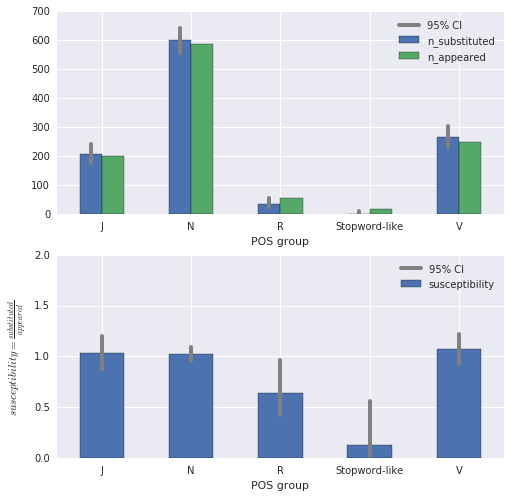

In [8]:
# Compute POS counts.
susties_pos = words[words.feature == 'aoa']\
    .groupby('rPOS')['target']\
    .aggregate({'susceptibility': susty_all,
                'n_substituted': target_all_counts,
                'n_appeared': appeared_all_counts})\
    .rename_axis('POS group')

# Plot.

fig, axes = plt.subplots(2, 1, figsize=(8, 8))
# Raw substituted and appeared values.
susties_pos[['n_substituted', 'n_appeared']]\
    .plot(ax=axes[0], kind='bar', rot=0)
# With their CIs.
total_substituted = susties_pos.n_substituted.sum()
cis = multinomial_proportions_confint(susties_pos.n_substituted.round(),
                                      method='goodman')
for i in range(len(susties_pos)):
    axes[0].plot([i-.125, i-.125], cis[i] * total_substituted,
                 lw=4, color='grey',
                 label='95% CI' if i == 0 else None)
axes[0].legend()
# Substitutability values.
susties_pos['susceptibility']\
    .plot(ax=axes[1], kind='bar', legend=True, ylim=(0, 2), rot=0)
axes[1].set_ylabel(r'$susceptibility = \frac{substituted}{appeared}$')
# With their CIs.
for i in range(len(susties_pos)):
    axes[1].plot([i, i], (cis[i] * total_substituted 
                          / susties_pos.n_appeared.iloc[i]),
                 lw=4, color='grey',
                 label='95% CI' if i == 0 else None)
axes[1].legend(loc='best')
# Save if necessary.
if SAVE_FIGURES:
    fig.savefig(settings.FIGURE.format('all-susceptibilities-pos'),
                bbox_inches='tight', dpi=300)

**Note on confidence intervals**

Here we're in case (3) of the explanation below on confidence intervals (in section 3): it's really like a multinomial sampling, but not quite since not all POS tags are available to sample from in all the sentences. There's no way out of this, so we're going to use multinomial CIs. We can safely scale all the bars and CIs to their respective `n_appeared` values, since that is an independent given before the sampling.

**Are the appeared and substituted proportions statistically different?**

The only test we can easily do is a multinomial goodness-of-fit. This tells us if the `n_substituted` counts are significantly different from the reference `n_appeared` counts.

From there on we know a few things:
* Comparing a given POS's `n_substituted` count to its reference `n_appeared` count tells us if it's statistically different (< or >). We know this will be true individually for any POS that is out of its confidence region for the global goodness-of-fit test, since it's a weaker hypothesis (so the null rejection region will be wider, and the POS we're looking at is already in the rejection region for the global test). We don't know if it'll be true or not for POSes that are in their confidence region for the global test.
* Jointly comparing two POS's `n_substituted` counts to their reference `n_appeared` counts tells us if there is bias for one w.r.t. the other. This is also true for all pairs of POSes that are on alternate sides of their confidence region in the global test (for the same reasons as in the previous point). We don't know if it's true for the other POSes though.

In [9]:
# Test the n_substituted proportions are different from
# the n_appeared proportions
total_appeared = susties_pos.n_appeared.sum()
appeared_cis = multinomial_proportions_confint(
    susties_pos.n_appeared.round(), method='goodman')
differences = [(s < ci[0] * total_appeared) or (s > ci[1] * total_appeared)
               for s, ci in zip(susties_pos.n_substituted, appeared_cis)]
are_different = np.any(differences)
if are_different:
    print("Appeared and substituted proportions are different with p < .05")
    print("The following POS tags are out of their confidence region:",
          list(susties_pos.index[np.where(differences)[0]]))
else:
    print("Appeared and substituted proportions cannot be "
          "said different with p value better than .05")

Appeared and substituted proportions are different with p < .05
The following POS tags are out of their confidence region: ['R', 'Stopword-like']


## 3 On global feature values

Prepare plotting functions, for bin and quartile susceptibilities for each feature.

In [10]:
def print_significance(feature, h0s, heights):
    h0_total = h0s.sum()
    bin_count = len(h0s)
    print()
    print('-' * len(feature))
    print(feature)
    print('-' * len(feature))
    for n_stars, alpha in enumerate([.05, .01, .001]):
        h0_cis = multinomial_proportions_confint(h0s.round(),
                                                 method='goodman',
                                                 alpha=alpha)
        differences = ((heights < h0_cis[:, 0] * h0_total)
                       | (heights > h0_cis[:, 1] * h0_total))
        are_different = np.any(differences)
        stars = ' ' * (3 - n_stars) + '*' * (1 + n_stars)
        if are_different:
            bins_different = np.where(differences)[0]
            bins_different += np.ones_like(bins_different)
            print(stars + ' Target different H_0 with p < {}.'
                  ' Bins [1; {}] out of region: {}'
                  .format(alpha, bin_count, bins_different.tolist()))
        else:
            print('     Target NOT different from H_0 (p > {})'
                  .format(alpha))
            break

In [11]:
def plot_bin_susties(**kwargs):
    data = kwargs['data']
    feature = data.iloc[0].feature
    color = kwargs.get('color', 'blue')
    relative = kwargs.get('relative', False)
    quantiles = kwargs.get('quantiles', False)
    value = data.value_rel if relative else data.value
    
    # Compute binning.
    cut, cut_kws = ((pd.qcut, {}) if quantiles
                    else (pd.cut, {'right': False}))
    for bin_count in range(BIN_COUNT, 0, -1):
        try:
            value_bins, bins = cut(value, bin_count, labels=False,
                                   retbins=True, **cut_kws)
            break
        except ValueError:
            pass
    middles = (bins[:-1] + bins[1:]) / 2

    # Compute bin counts. Note here the bins are computed on the
    # distribution of observed substitutions, not the simulated aggregated
    # distributions of cluster-unit substitutions. But since it's mostly
    # deduplication that the aggregation process addresses, the bins
    # should be mostly the same. This could be corrected by computing
    # bins on the aggregate distribution (not hard), but it's really
    # not important now.
    heights = np.zeros(bin_count)
    h0s = np.zeros(bin_count)
    for i in range(bin_count):
        heights[i] = (data[data.target & (value_bins == i)]
                      .weight_feature.sum())
        h0s[i] = data[value_bins == i].weight_feature_appeared.sum()
    total = sum(heights)
    cis = (multinomial_proportions_confint(heights.round(),
                                           method='goodman')
           * total / h0s[:, np.newaxis])
    
    # Plot them.
    sigmaphi = (r'\sigma_{\phi'
                + ('_r' if relative else '')
                + '}')
    plt.plot(middles, heights / h0s, 
             color=color, label='${}$'.format(sigmaphi))
    plt.fill_between(middles, cis[:, 0], cis[:, 1],
                     color=sb.desaturate(color, 0.2), alpha=0.2)
    plt.plot(middles, np.ones_like(middles), '--',
             color=sb.desaturate(color, 0.2),
             label='${}^0$'.format(sigmaphi))
    plt.xlim(middles[0], middles[-1])
    plt.ylim(0, 2)
    
    # Test for statistical significance
    print_significance(feature, h0s, heights)

In [12]:
def plot_grid(data, features, filename,
              plot_function, xlabel, ylabel, plot_kws={}):
    g = sb.FacetGrid(data=data[data['feature']
                               .map(lambda f: f in features)],
                     sharex=False, sharey=True,
                     col='feature', hue='feature',
                     col_order=features, hue_order=features,
                     col_wrap=3, aspect=1.5, size=3)
    g.map_dataframe(plot_function, **plot_kws)
    g.set_titles('{col_name}')
    g.set_xlabels(xlabel)
    g.set_ylabels(ylabel)
    for ax in g.axes.ravel():
        legend = ax.legend(frameon=True, loc='best')
        if not legend:
            # Skip if nothing was plotted on these axes.
            continue
        frame = legend.get_frame()
        frame.set_facecolor('#f2f2f2')
        frame.set_edgecolor('#000000')
        ax.set_title(Substitution._transformed_feature(ax.get_title())
                     .__doc__)
    if SAVE_FIGURES:
        g.fig.savefig(settings.FIGURE.format(filename),
                      bbox_inches='tight', dpi=300)

### 3.1 Bins of distribution of appeared global feature values


-------------
letters_count
-------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 2, 3]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 2, 3]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 2]

--------------
phonemes_count
--------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 2, 3]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 2, 3]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 2, 3]



---------------
syllables_count
---------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 2, 3]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 2, 3]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 3]

---
aoa
---
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 3]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 3]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 3]



--------------
synonyms_count
--------------
     Target NOT different from H_0 (p > 0.05)

-----------
betweenness
-----------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1]



----------
clustering
----------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [3, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [3, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [4]

------
degree
------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [2]
     Target NOT different from H_0 (p > 0.01)



---------
frequency
---------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 2, 3, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 2, 3, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [2, 4]

--------------------
orthographic_density
--------------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 3, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 3, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 3, 4]



--------
pagerank
--------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 2]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 2]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 2]

--------------------
phonological_density
--------------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 4]


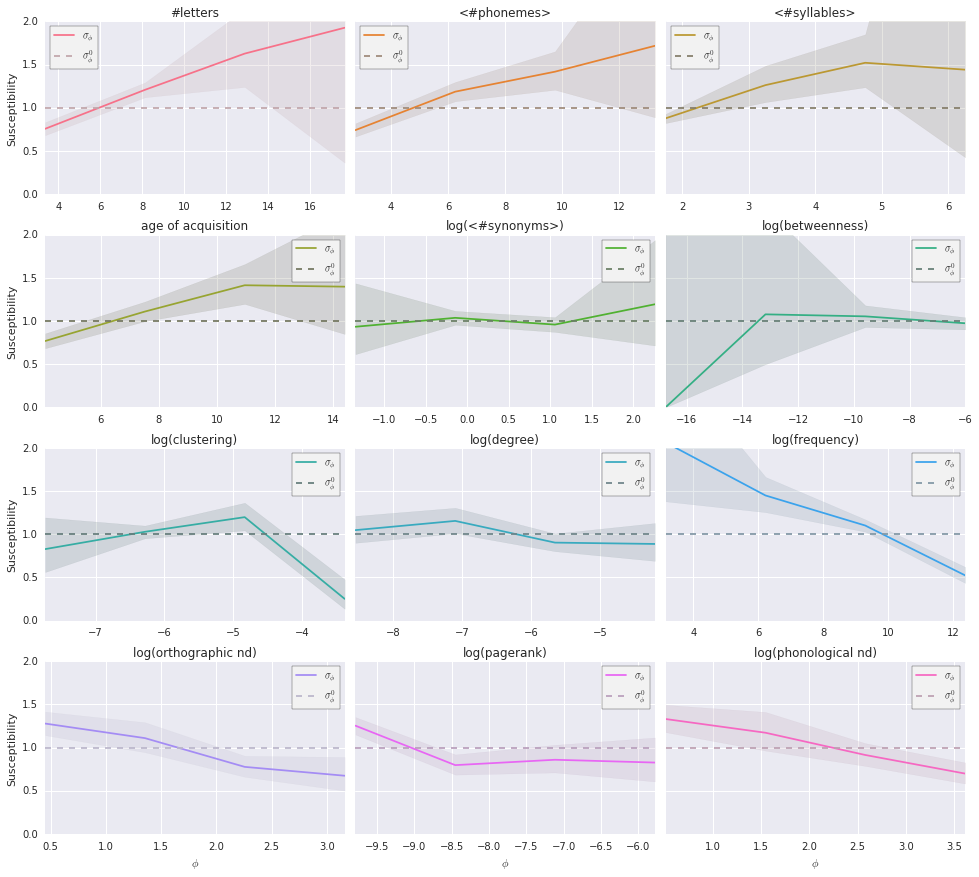

In [13]:
plot_grid(words, ordered_features,
          'all-susceptibilities-fixedbins_global',
          plot_bin_susties, r'$\phi$', 'Susceptibility')

**Note on how graphs and their confidence intervals are computed here**

There are three ways I can do a computation like above:

(1) For each word, we look at how many times it is substituted versus how many times it appears in a position where it could have been substituted. This is the *word*'s susceptibility, $\sigma(w)$. Then for each feature bin $b_i$ we take all the words such that $\phi(w) \in b_i$, average, and compute an asymptotic confidence interval based on how many words are in the bin. This fails for sentence-relative features, because a given word has different feature values depending on the sentence it appears in. So we discard this.

(2) Do the same but at the feature value level. So we define a *feature value* susceptibility, $\sigma_{\phi}(f)$, and compute a confidence interval based on how many different feature values we have in the bin. The idea behind (1) and (2) is to look at the bin middle-value like the relevant object we're measuring, and we have several measures for each bin middle-value, hence the confidence interval. In each bin $b_i$ we have:

$$\left< \sigma_{\phi}(f) \right>_{f \in b_i}$$

The problem with both (1) and (2) is that there's no proper $\mathcal{H}_0$ value, because the averages in the bins don't necessarily equal 1 under $\mathcal{H}_0$. Also, we can't check that there is consistency, showing that the sum of susceptibility values of the bins is 1. Hence case 3:

(3) Consider that we sample a multinomial process: each substitution is in fact the sampling of a feature value from one of the four bins. In that case, we can compute multinomial proportion CIs. This is also not completely satisfactory since in most cases not all feature values are available at the time of sampling, since most sentences don't range over all the feature's values, but it's what lets us compute proper null hypotheses: in each bin $b_i$ we have a value of $\sigma_{\phi}(b_i)$, and the sum of those should be the same under $\mathcal{H}_0$ as in the experiment (in practice in the graphs, we divide by the values under $\mathcal{H}_0$, and the reference is $\sigma_{\phi}^0(b_i) = 1$).

Here and below, we're always in case (3).


---------
frequency
---------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 2, 3, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 2, 3, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [2, 4]

---
aoa
---
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 3, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 3]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 3]



----------
clustering
----------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [3, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [3, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [4]

-------------
letters_count
-------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 3]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 3]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 3]



--------------
synonyms_count
--------------
     Target NOT different from H_0 (p > 0.05)

--------------------
orthographic_density
--------------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 3, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 3, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 3, 4]


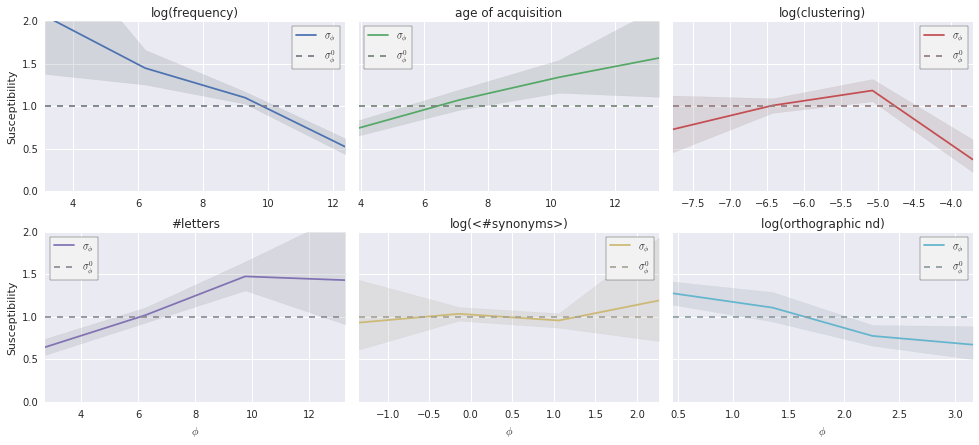

In [14]:
plot_grid(words[~(((words.feature == 'letters_count') 
                   & (words.value > 15))
                  | ((words.feature == 'aoa') 
                     & (words.value > 15))
                  | ((words.feature == 'clustering') 
                     & (words.value > -3)))],
          PAPER_FEATURES,
          'paper-susceptibilities-fixedbins_global',
          plot_bin_susties, r'$\phi$', 'Susceptibility')

### 3.2 Quantiles of distribution of appeared global feature values


-------------
letters_count
-------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 3, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 3, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 3, 4]

--------------
phonemes_count
--------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 3, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 3, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 4]



---------------
syllables_count
---------------
   * Target different H_0 with p < 0.05. Bins [1; 2] out of region: [1, 2]
  ** Target different H_0 with p < 0.01. Bins [1; 2] out of region: [1, 2]
 *** Target different H_0 with p < 0.001. Bins [1; 2] out of region: [1, 2]

---
aoa
---
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 4]



--------------
synonyms_count
--------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [3, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [4]

-----------
betweenness
-----------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 2]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1]



----------
clustering
----------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [3]
     Target NOT different from H_0 (p > 0.01)

------
degree
------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [4]
     Target NOT different from H_0 (p > 0.01)



---------
frequency
---------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 2, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 2, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 2, 4]

--------------------
orthographic_density
--------------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 3, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 3]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 3]



--------
pagerank
--------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 2, 3, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 3, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 4]

--------------------
phonological_density
--------------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 4]


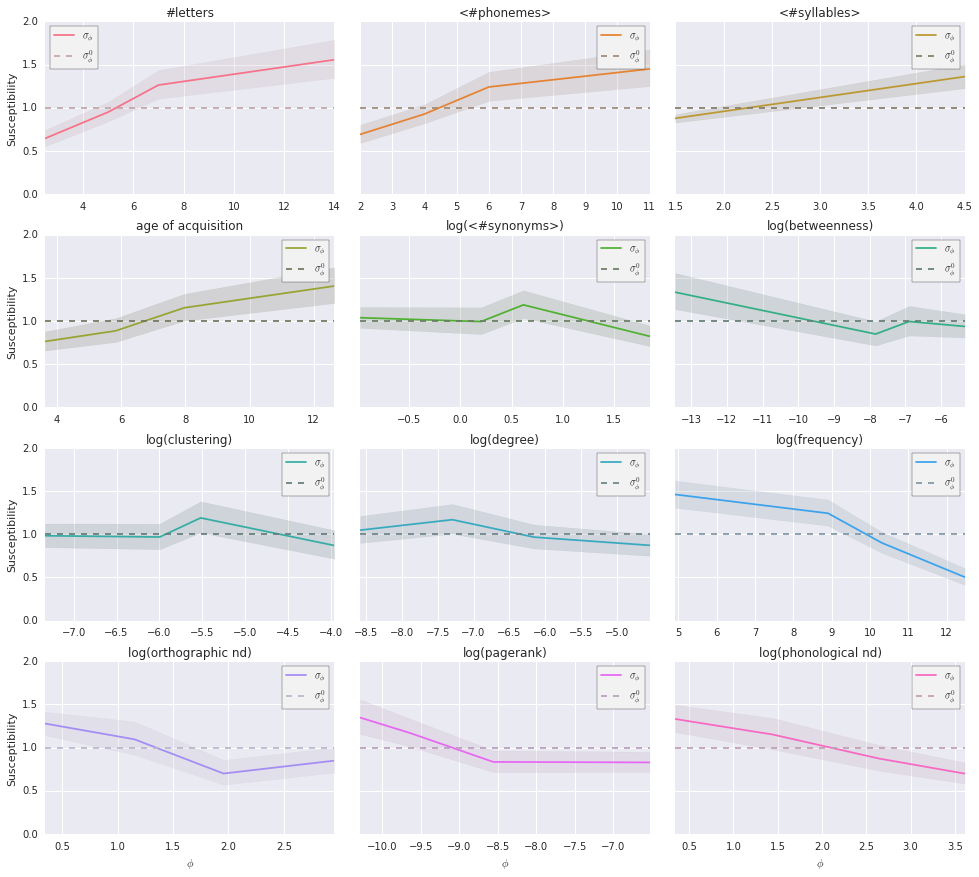

In [15]:
plot_grid(words, ordered_features,
          'all-susceptibilities-quantilebins_global', plot_bin_susties,
          r'$\phi$', 'Susceptibility',
          plot_kws={'quantiles': True})

**Note on confidence intervals**

Here we're again in case (2) of the above explanation on confidence intervals (in section 3.1), since we're just binning by quantiles instead of fixed-width bins.


---------
frequency
---------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 2, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 2, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 2, 4]

---
aoa
---
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 4]



----------
clustering
----------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [3]
     Target NOT different from H_0 (p > 0.01)

-------------
letters_count
-------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 3, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 3, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 3, 4]



--------------
synonyms_count
--------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [3, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [4]

--------------------
orthographic_density
--------------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 3, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 3]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 3]


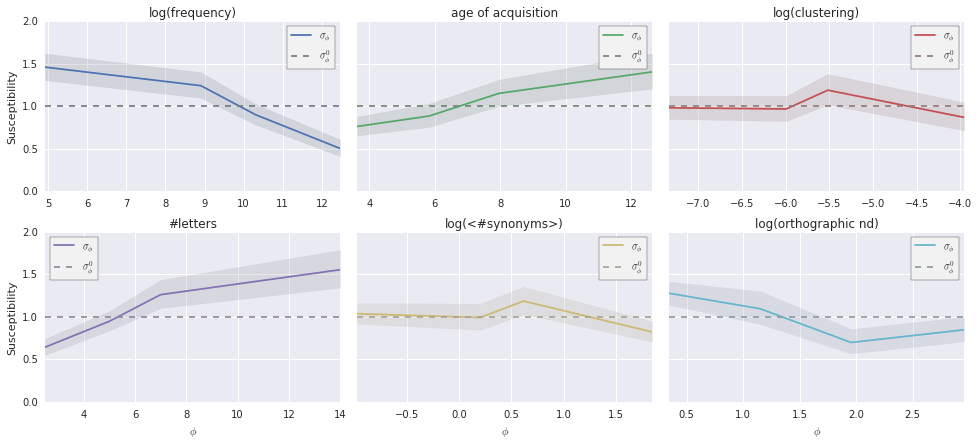

In [16]:
plot_grid(words, PAPER_FEATURES,
          'paper-susceptibilities-quantilebins_global', plot_bin_susties,
          r'$\phi$', 'Susceptibility',
          plot_kws={'quantiles': True})

## 4 On sentence-relative feature values

### 4.1 Bins of distribution of appeared sentence-relative values


-------------
letters_count
-------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 3]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 3]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 3]

--------------
phonemes_count
--------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 2, 3]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 2, 3]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 3]



---------------
syllables_count
---------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [2, 3]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [2, 3]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [2, 3]

---
aoa
---
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [2, 3, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [2, 3]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [2, 3]



--------------
synonyms_count
--------------
     Target NOT different from H_0 (p > 0.05)

-----------
betweenness
-----------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1]



----------
clustering
----------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [4]

------
degree
------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 3]
     Target NOT different from H_0 (p > 0.01)



---------
frequency
---------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 2, 3, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 2, 3, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 2, 3, 4]

--------------------
orthographic_density
--------------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 3, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 3, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 3, 4]



--------
pagerank
--------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 3, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1]
     Target NOT different from H_0 (p > 0.001)

--------------------
phonological_density
--------------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 3]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 3]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 3]


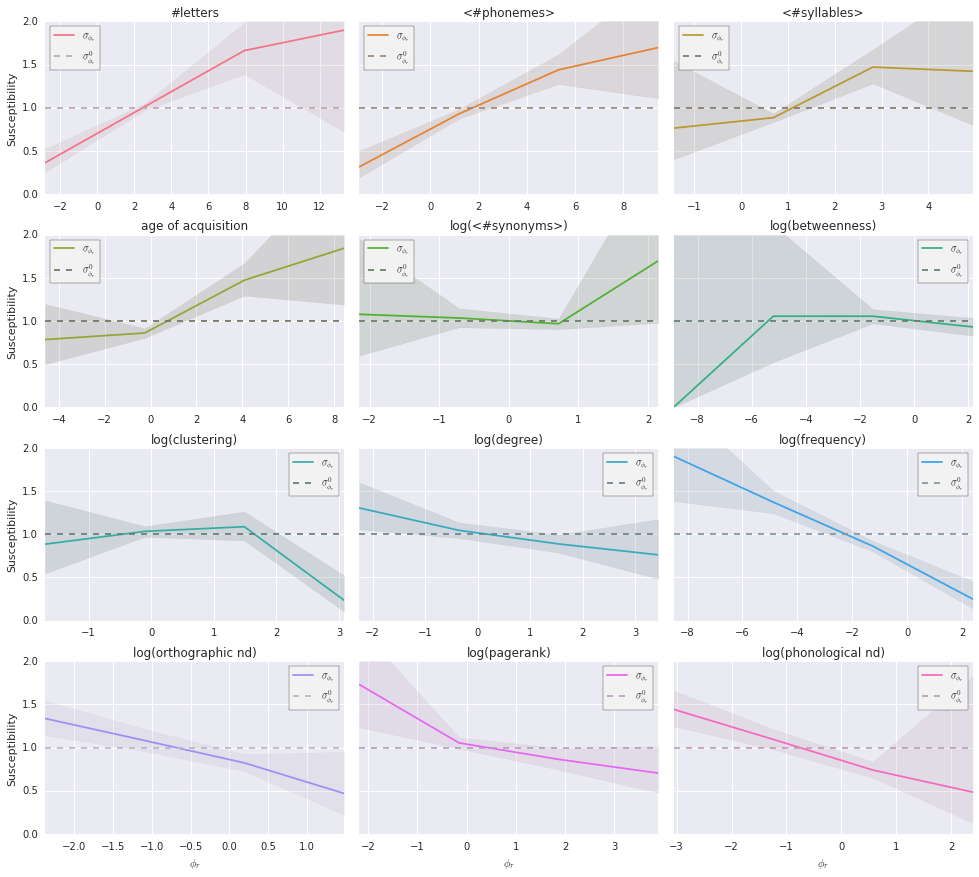

In [17]:
plot_grid(words, ordered_features,
          'all-susceptibilities-fixedbins_sentencerel',
          plot_bin_susties, r'$\phi_r$', 'Susceptibility',
          plot_kws={'relative': True})


---------
frequency
---------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 2, 3, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 2, 3, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 2, 3, 4]

---
aoa
---
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [2, 3, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [2, 3]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [2, 3]



----------
clustering
----------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [4]

-------------
letters_count
-------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 3]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 3]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 3]



--------------
synonyms_count
--------------
     Target NOT different from H_0 (p > 0.05)

--------------------
orthographic_density
--------------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 3, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 3, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 3, 4]


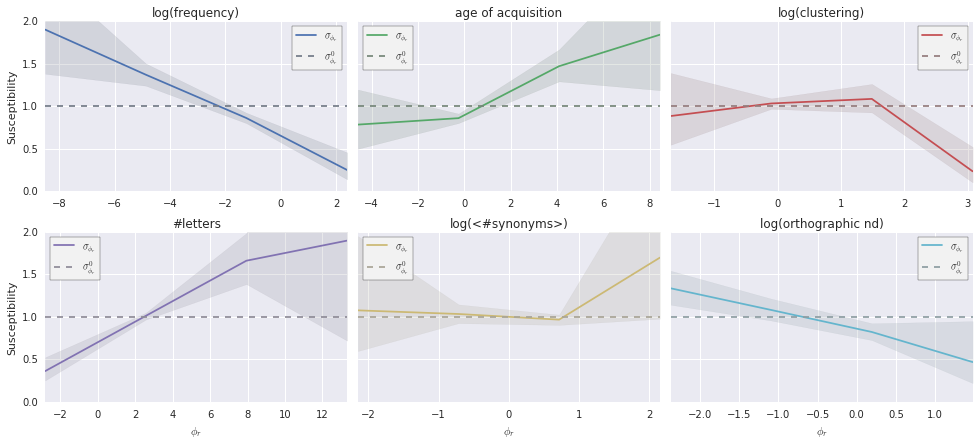

In [18]:
plot_grid(words, PAPER_FEATURES,
          'paper-susceptibilities-fixedbins_sentencerel',
          plot_bin_susties, r'$\phi_r$', 'Susceptibility',
          plot_kws={'relative': True})

### 4.2 Quantiles of distribution of appeared sentence-relative values


-------------
letters_count
-------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 4]

--------------
phonemes_count
--------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 4]



---------------
syllables_count
---------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 3, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 3, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 3, 4]

---
aoa
---
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 2, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 2, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 4]



--------------
synonyms_count
--------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [4]
     Target NOT different from H_0 (p > 0.01)

-----------
betweenness
-----------
     Target NOT different from H_0 (p > 0.05)



----------
clustering
----------
     Target NOT different from H_0 (p > 0.05)

------
degree
------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [4]
     Target NOT different from H_0 (p > 0.001)



---------
frequency
---------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 3, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 3, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 3, 4]

--------------------
orthographic_density
--------------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 3, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 4]



--------
pagerank
--------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 3, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1]

--------------------
phonological_density
--------------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 4]


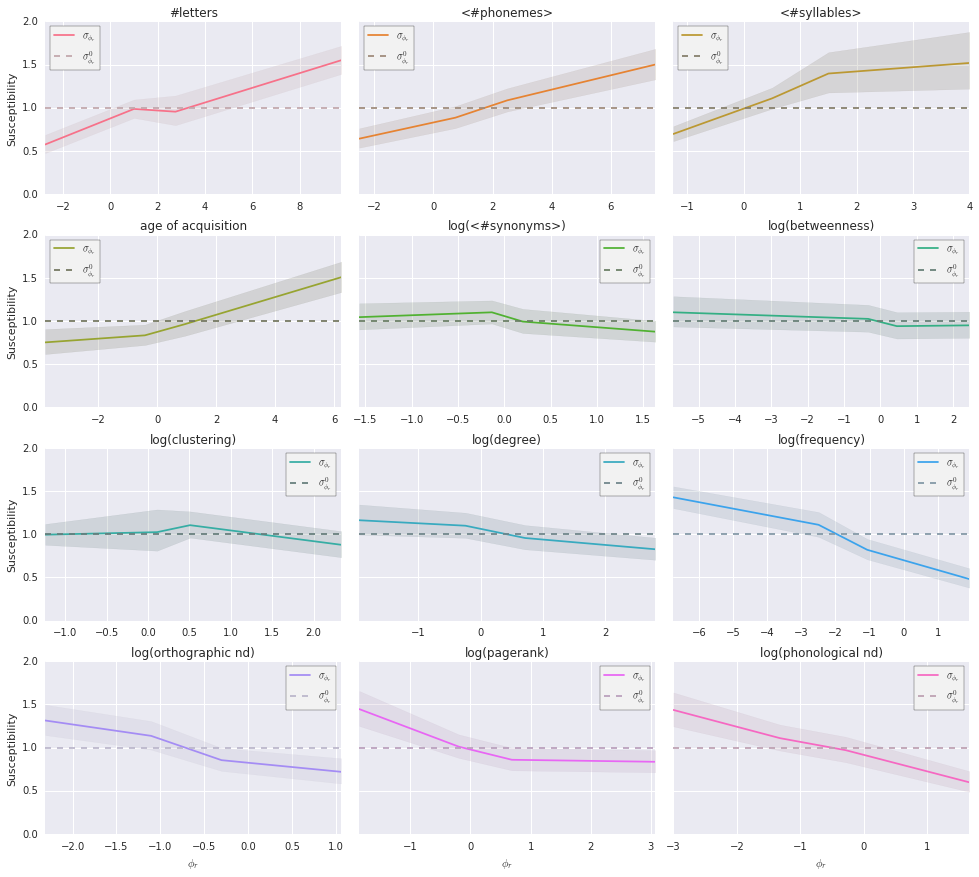

In [19]:
plot_grid(words, ordered_features,
          'all-susceptibilities-quantilebins_sentencerel',
          plot_bin_susties, r'$\phi_r$', 'Susceptibility',
          plot_kws={'quantiles': True, 'relative': True})


---------
frequency
---------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 3, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 3, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 3, 4]

---
aoa
---
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 2, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 2, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 4]



----------
clustering
----------
     Target NOT different from H_0 (p > 0.05)

-------------
letters_count
-------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 4]



--------------
synonyms_count
--------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [4]
     Target NOT different from H_0 (p > 0.01)

--------------------
orthographic_density
--------------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 3, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 4]


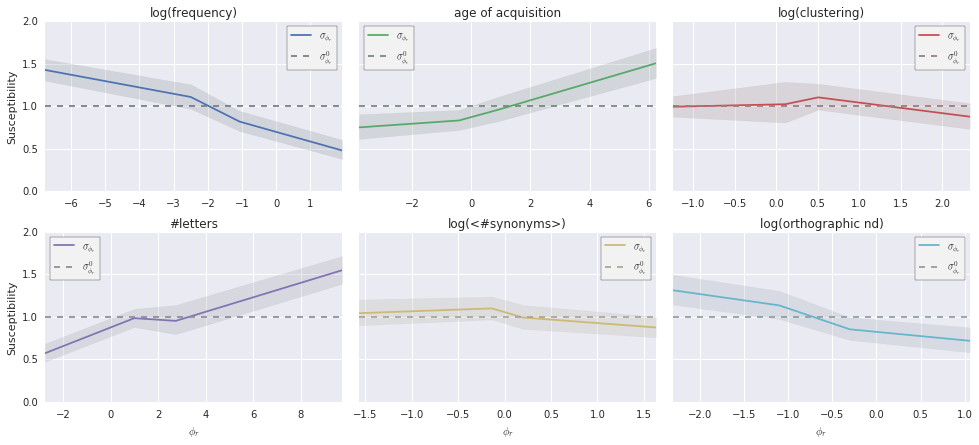

In [20]:
plot_grid(words, PAPER_FEATURES,
          'paper-susceptibilities-quantilebins_sentencerel',
          plot_bin_susties, r'$\phi_r$', 'Susceptibility',
          plot_kws={'quantiles': True, 'relative': True})

## 5 On quantiles and bins of the in-sentence distributions

### 5.1 In-sentence bins (of distribution of values in each sentence)

In [21]:
def plot_sentencebin_susties(**kwargs):
    data = kwargs['data']
    color = kwargs.get('color', 'blue')
    feature = data.iloc[0].feature
    
    # Compute bin counts
    heights = np.zeros(BIN_COUNT)
    h0s = np.zeros(BIN_COUNT)
    for i in range(BIN_COUNT):
        heights[i] = (data[data.target & (data.bin == i)]
                      .weight_feature.sum())
        h0s[i] = data[data.bin == i].weight_feature_appeared.sum()
    total = sum(heights)
    cis = (multinomial_proportions_confint(heights.round(),
                                           method='goodman')
           * total / h0s[:, np.newaxis])
    
    # Plot them.
    sigmaphi = r'\sigma_{bin_{\phi}}'
    x = range(1, BIN_COUNT + 1)
    plt.plot(x, heights / h0s, color=color, label='${}$'.format(sigmaphi))
    plt.fill_between(x, cis[:, 0], cis[:, 1],
                     color=sb.desaturate(color, 0.2), alpha=0.2)
    plt.plot(x, np.ones_like(x), '--',
             color=sb.desaturate(color, 0.2),
             label='${}^0$'.format(sigmaphi))
    plt.xticks(x)
    plt.ylim(0, None)
    
    # Test for significance.
    print_significance(feature, h0s, heights)


-------------
letters_count
-------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 4]

--------------
phonemes_count
--------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 4]



---------------
syllables_count
---------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 4]

---
aoa
---
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 4]



--------------
synonyms_count
--------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 4]
     Target NOT different from H_0 (p > 0.01)

-----------
betweenness
-----------
     Target NOT different from H_0 (p > 0.05)



----------
clustering
----------
     Target NOT different from H_0 (p > 0.05)

------
degree
------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1]



---------
frequency
---------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 3, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 3, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 4]

--------------------
orthographic_density
--------------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 4]



--------
pagerank
--------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 4]

--------------------
phonological_density
--------------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 4]


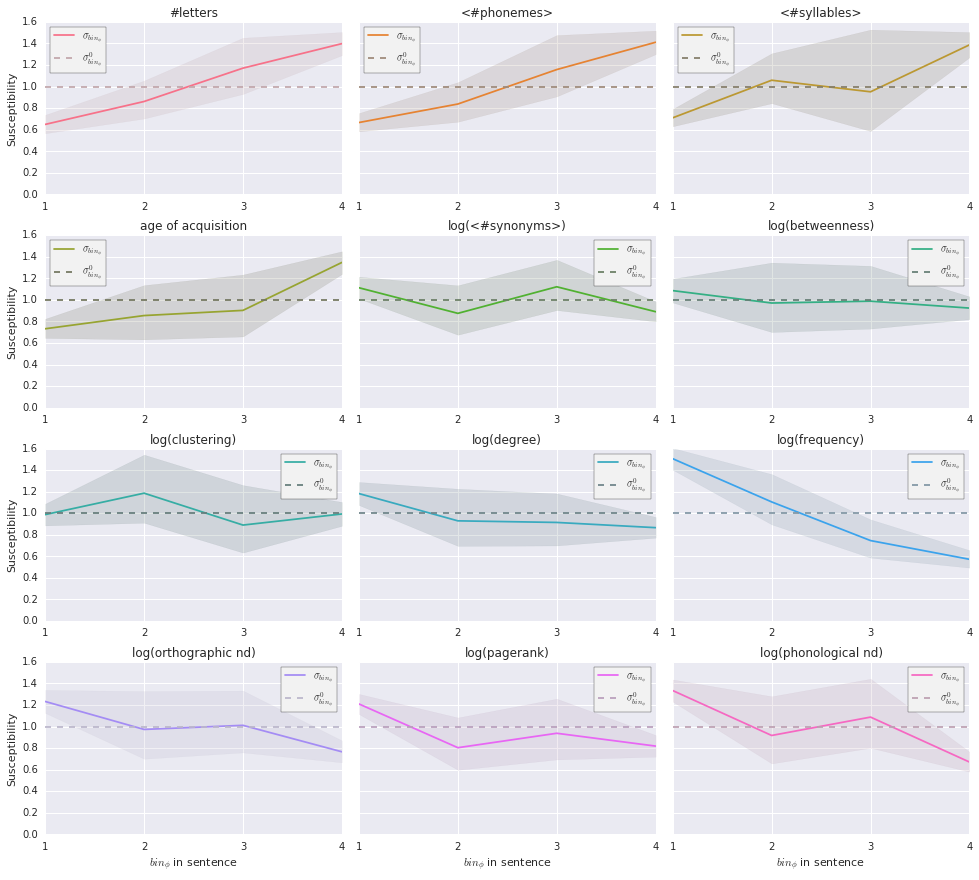

In [22]:
plot_grid(words, ordered_features,
          'all-susceptibilities-sentencebins',
          plot_sentencebin_susties, r'$bin_{\phi}$ in sentence',
          'Susceptibility')


---------
frequency
---------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 3, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 3, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 4]

---
aoa
---
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 4]



----------
clustering
----------
     Target NOT different from H_0 (p > 0.05)

-------------
letters_count
-------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 4]



--------------
synonyms_count
--------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 4]
     Target NOT different from H_0 (p > 0.01)

--------------------
orthographic_density
--------------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 4]


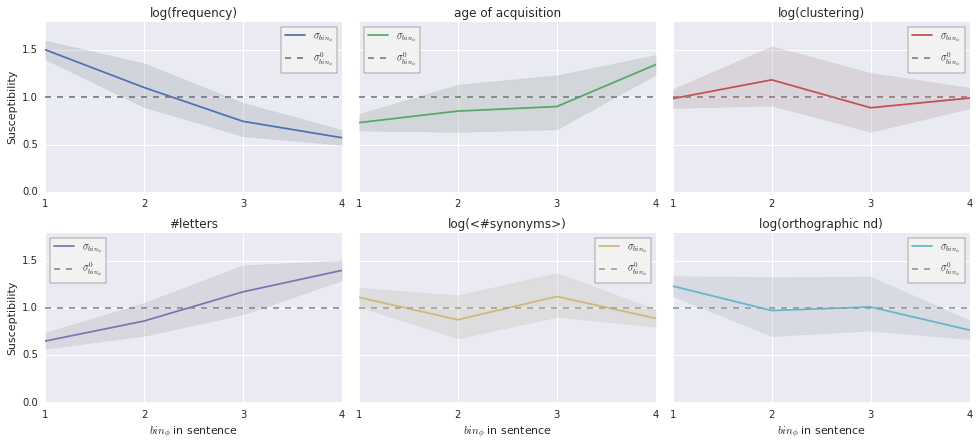

In [23]:
plot_grid(words, PAPER_FEATURES,
          'paper-susceptibilities-sentencebins',
          plot_sentencebin_susties, r'$bin_{\phi}$ in sentence',
          'Susceptibility')

### 5.2 In-sentence quantiles (of distribution of values in each sentence)

For each feature, count the sum of weights in each bin and plot that.

In [24]:
def bound(limits, values):
    left, right = limits
    assert left < right
    return np.maximum(left, np.minimum(right, values))

In [25]:
def plot_sentencequantile_susties(**kwargs):
    data = kwargs['data']
    color = kwargs.get('color', 'blue')
    feature = data.iloc[0].feature
    
    # Compute bin counts
    heights = np.zeros(BIN_COUNT)
    h0s = np.zeros(BIN_COUNT)
    step = 1 / BIN_COUNT
    for i in range(BIN_COUNT):
        limits = [i * step, (i + 1) * step]
        contributions = ((bound(limits, data.stop_quantile)
                          - bound(limits, data.start_quantile))
                         / (data.stop_quantile - data.start_quantile))
        heights[i] = \
            (contributions * data.weight_feature)[data.target].sum()
        h0s[i] = (contributions * data.weight_feature_appeared).sum()
    total = sum(heights)
    cis = (multinomial_proportions_confint(heights.round(),
                                           method='goodman')
           * total)# / h0s[:, np.newaxis])
    
    # Plot them.
    sigmaphi = r'\sigma_{q_{\phi}}'
    x = range(1, BIN_COUNT + 1)
    plt.plot(x, heights,# / h0s,
             color=color, label='${}$'.format(sigmaphi))
    plt.fill_between(x, cis[:, 0], cis[:, 1],
                     color=sb.desaturate(color, 0.2), alpha=0.2)
    plt.plot(x, h0s, '--',
             color=sb.desaturate(color, 0.2),
             label='${}^0$'.format(sigmaphi))
    plt.xticks(x)
    plt.ylim(0, None)
    
    # Test for significance.
    print_significance(feature, h0s, heights)


-------------
letters_count
-------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 2, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 2, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 4]

--------------
phonemes_count
--------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 2, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 2, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 4]



---------------
syllables_count
---------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 2, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 2, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 2, 4]

---
aoa
---
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 2, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 2, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 2, 4]



--------------
synonyms_count
--------------
     Target NOT different from H_0 (p > 0.05)

-----------
betweenness
-----------
     Target NOT different from H_0 (p > 0.05)



----------
clustering
----------
     Target NOT different from H_0 (p > 0.05)

------
degree
------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 4]
     Target NOT different from H_0 (p > 0.001)



---------
frequency
---------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 2, 3, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 2, 3, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 3, 4]

--------------------
orthographic_density
--------------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 3, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 4]



--------
pagerank
--------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 3, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 4]

--------------------
phonological_density
--------------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 2, 3, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 4]


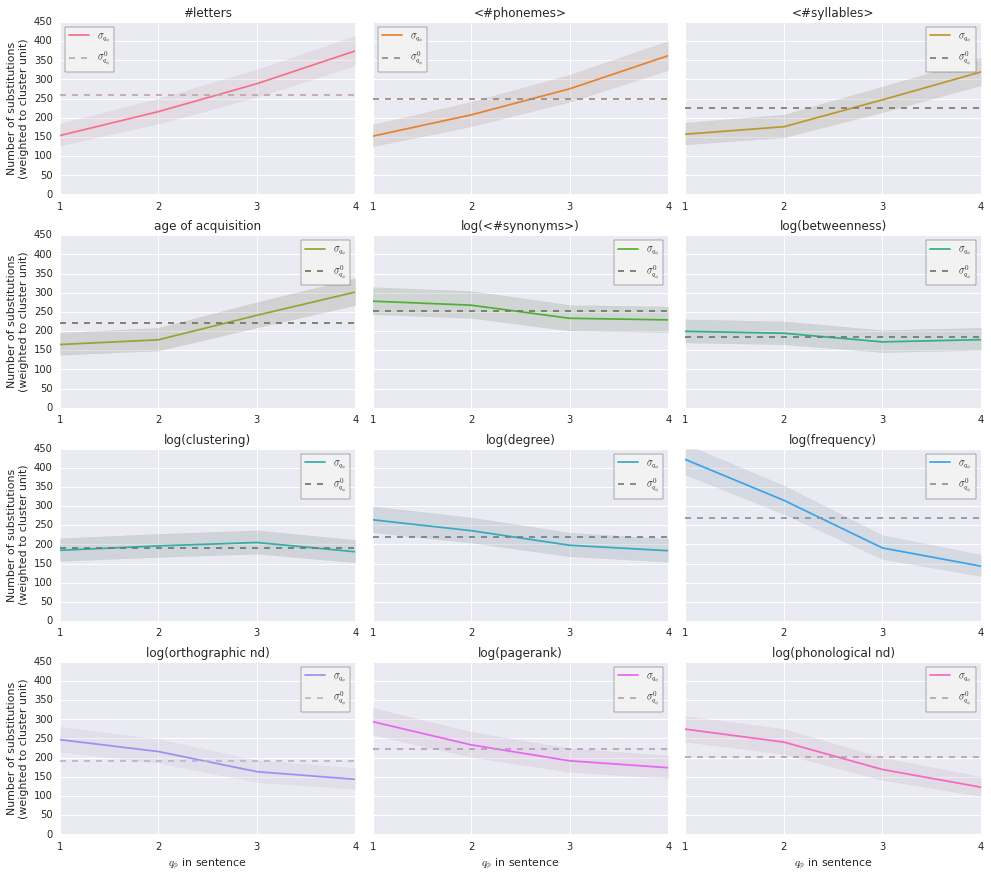

In [26]:
plot_grid(words, ordered_features,
          'all-susceptibilities-sentencequantiles',
          plot_sentencequantile_susties, r'$q_{\phi}$ in sentence',
          'Number of substitutions\n(weighted to cluster unit)')


---------
frequency
---------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 2, 3, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 2, 3, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 3, 4]

---
aoa
---
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 2, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 2, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 2, 4]



----------
clustering
----------
     Target NOT different from H_0 (p > 0.05)

-------------
letters_count
-------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 2, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 2, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 4]



--------------
synonyms_count
--------------
     Target NOT different from H_0 (p > 0.05)

--------------------
orthographic_density
--------------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 3, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 4]


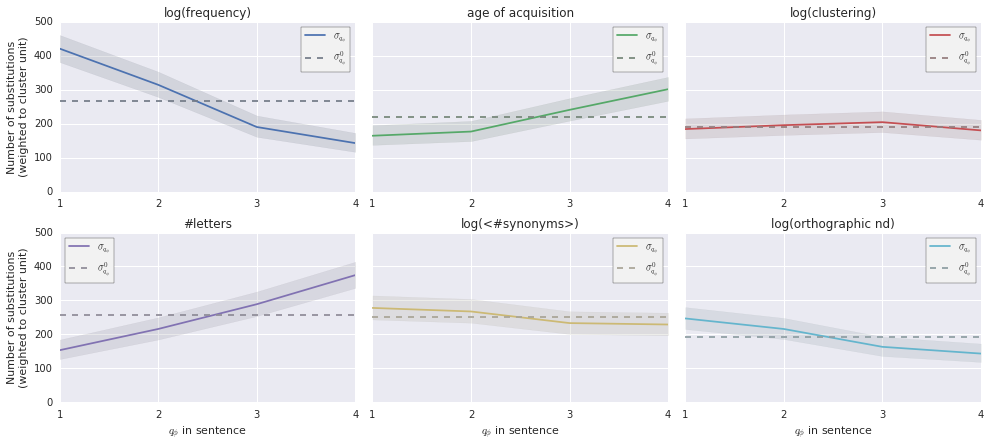

In [27]:
plot_grid(words, PAPER_FEATURES,
          'paper-susceptibilities-sentencequantiles',
          plot_sentencequantile_susties, r'$q_{\phi}$ in sentence',
          'Number of substitutions\n(weighted to cluster unit)')

## 6 Regression on significant features

### 6.1 Multinomial logistic regression

We try to predict which words are substituted, based on their global values, sentence-relative values, bins and quantiles of those, or in-sentence bin values.

Prediction is not good, mainly because the constraint of one-substitution-per-sentence can't be factored in the model simply. So precision is generally very low, around .20-.25, and when accuracy goes up recall plummets.

So it might show some interaction effects, but given that the fit is very bad I wouldn't trust it.

In-sentence quantiles (from section 5.2) were not done, as they're impossible to reduce to one value (our measure of those quantiles is in fact a subrange of [0, 1] for each word, corresponding to the subrange of the sentence distribution that that word's feature value represented).

In [28]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import PolynomialFeatures
from scipy.stats import binom_test

In [29]:
def regress_binning(data, features, value_funcs):
    # Compute bins
    data = data.copy()
    regress_features = [('{}'.format(value_name), feature)
                        for value_name in value_funcs.keys()
                        for feature in features]
    for i, (value_name, value_func) in enumerate(value_funcs.items()):
        data[value_name] = value_func(data)
    
    # Massage the dataframe to have feature bin as columns.
    data_wide = pd.pivot_table(
        data,
        values=list(value_funcs.keys()),
        index=['destination_id', 'occurrence', 'source_id', 'position',
               'word_position'],
        columns=['feature']
    )[regress_features]

    # Add the target value.
    # Question/FIXME: should we use weight_appeared for regression?
    data_wide['target'] = pd.pivot_table(
        data,
        values=['target'],
        index=['destination_id', 'occurrence', 'source_id', 'position',
               'word_position'],
        columns=['feature']
    )[('target', 'aoa')]
    data_wide = data_wide.dropna()

    # Compute polynomial features.
    poly = PolynomialFeatures(degree=2, interaction_only=True)
    pdata = poly.fit_transform(data_wide[regress_features])
    pregress_features = [' * '.join(['_'.join(regress_features[j])
                                   for j, p in enumerate(powers)
                                   if p > 0]) or 'intercept'
                         for powers in poly.powers_]

    # Divide into two sets.
    print('Regressing with {} word measures (divided into'
          ' training and prediction sets)'
          .format(len(data_wide)))
    pdata_train = pdata[:len(data_wide) // 2]
    target_train = data_wide.iloc[:len(data_wide) // 2].target
    pdata_predict = pdata[len(data_wide) // 2:]
    target_predict = data_wide.iloc[len(data_wide) // 2:].target
    assert len(pdata_train) + len(pdata_predict) == len(data_wide)
    assert len(target_train) + len(target_predict) == len(data_wide)
    
    # Regress
    regressor = LogisticRegression(penalty='l2', class_weight='balanced',
                                   fit_intercept=False)
    regressor.fit(pdata_train, target_train)
    
    # And predict
    prediction = regressor.predict(pdata_predict)
    standard = target_predict.values
    success = prediction == standard
    
    tp = prediction & standard
    tn = (~prediction) & (~standard)
    fp = prediction & (~standard)
    fn = (~prediction) & standard
    
    print()
    print('{:.2f}% of words well predicted (non-random at p = {:.1})'
          .format(100 * success.mean(),
                  binom_test(success.sum(), len(success))))
    print('Precision = {:.2f}'.format(standard[prediction].mean()))
    print('Recall = {:.2f}'.format(prediction[standard].mean()))
    print()
    print('Coefficients:')
    print(pd.Series(index=pregress_features, data=regressor.coef_[0]))

**Global feature value**

In [30]:
regress_binning(words, ['frequency', 'aoa', 'letters_count',
                        'orthographic_density'],
                {'global': lambda d: d.value})

Regressing with 25141 word measures (divided into training and prediction sets)



55.13% of words well predicted (non-random at p = 1e-30)
Precision = 0.37
Recall = 0.62

Coefficients:
intercept                                             4.482598
global_frequency                                     -0.288866
global_aoa                                           -0.908265
global_letters_count                                  0.785964
global_orthographic_density                          -1.141601
global_frequency * global_aoa                         0.074359
global_frequency * global_letters_count              -0.095660
global_frequency * global_orthographic_density        0.087462
global_aoa * global_letters_count                     0.014109
global_aoa * global_orthographic_density              0.072486
global_letters_count * global_orthographic_density   -0.057725
dtype: float64


**Sentence-relative feature value**

In [31]:
regress_binning(words, ['frequency', 'aoa', 'letters_count',
                        'orthographic_density'],
                {'sentence-rel': lambda d: d.value_rel})

Regressing with 25141 word measures (divided into training and prediction sets)

65.19% of words well predicted (non-random at p = 4e-258)
Precision = 0.45
Recall = 0.59

Coefficients:
intercept                                                        -0.368934
sentence-rel_frequency                                           -0.199137
sentence-rel_aoa                                                 -0.048169
sentence-rel_letters_count                                       -0.013945
sentence-rel_orthographic_density                                 0.160557
sentence-rel_frequency * sentence-rel_aoa                         0.013155
sentence-rel_frequency * sentence-rel_letters_count               0.041405
sentence-rel_frequency * sentence-rel_orthographic_density        0.157314
sentence-rel_aoa * sentence-rel_letters_count                     0.099040
sentence-rel_aoa * sentence-rel_orthographic_density              0.154857
sentence-rel_letters_count * sentence-rel_orthographic_density   

**Global + sentence-relative feature values**

In [32]:
regress_binning(words, ['frequency', 'aoa', 'letters_count',
                        'orthographic_density'],
                {'global': lambda d: d.value,
                 'sentence-rel': lambda d: d.value_rel})

Regressing with 25141 word measures (divided into training and prediction sets)



59.28% of words well predicted (non-random at p = 1e-96)
Precision = 0.40
Recall = 0.62

Coefficients:
intercept                                                         -0.382748
sentence-rel_frequency                                            -0.387293
sentence-rel_aoa                                                  -0.171481
sentence-rel_letters_count                                        -1.430595
sentence-rel_orthographic_density                                  0.843177
global_frequency                                                   0.403150
global_aoa                                                        -1.938490
global_letters_count                                               2.374631
global_orthographic_density                                       -0.320907
sentence-rel_frequency * sentence-rel_aoa                         -0.157573
sentence-rel_frequency * sentence-rel_letters_count                0.052501
sentence-rel_frequency * sentence-rel_orthographic_density  

**(3.1) Bins of distribution of appeared global feature values**

In [33]:
regress_binning(words, ['frequency', 'aoa', 'letters_count',
                        'orthographic_density'],
                {'bins-global':
                     lambda d: pd.cut(d.value, BIN_COUNT,
                                      labels=False, right=False)})

Regressing with 25141 word measures (divided into training and prediction sets)

52.50% of words well predicted (non-random at p = 2e-08)
Precision = 0.36
Recall = 0.70

Coefficients:
intercept                                                      -1.568666
bins-global_frequency                                          -1.583163
bins-global_aoa                                                 4.065411
bins-global_letters_count                                      -0.824101
bins-global_orthographic_density                               -1.483652
bins-global_frequency * bins-global_aoa                        -0.741786
bins-global_frequency * bins-global_letters_count               1.460135
bins-global_frequency * bins-global_orthographic_density       -0.246980
bins-global_aoa * bins-global_letters_count                    -1.161955
bins-global_aoa * bins-global_orthographic_density             -0.436281
bins-global_letters_count * bins-global_orthographic_density    1.496424
dtype: float6

**(3.2) Quantiles of distribution of appeared global feature values**

In [34]:
regress_binning(words, ['frequency', 'aoa', 'letters_count',
                        'orthographic_density'],
                {'quantiles-global':
                     lambda d: pd.qcut(d.value, BIN_COUNT, labels=False)})

Regressing with 25141 word measures (divided into training and prediction sets)

38.17% of words well predicted (non-random at p = 2e-156)
Precision = 0.31
Recall = 0.80

Coefficients:
intercept                                                                 0.462642
quantiles-global_frequency                                               -0.452395
quantiles-global_aoa                                                     -0.207305
quantiles-global_letters_count                                            1.531831
quantiles-global_orthographic_density                                    -1.230309
quantiles-global_frequency * quantiles-global_aoa                        -0.083072
quantiles-global_frequency * quantiles-global_letters_count              -0.331079
quantiles-global_frequency * quantiles-global_orthographic_density        1.059307
quantiles-global_aoa * quantiles-global_letters_count                     0.181400
quantiles-global_aoa * quantiles-global_orthographic_density        

**(4.1) Bins of distribution of appeared sentence-relative values**

In [35]:
regress_binning(words, ['frequency', 'aoa', 'letters_count',
                        'orthographic_density'],
                {'bins-sentence-rel':
                     lambda d: pd.cut(d.value_rel, BIN_COUNT,
                                      labels=False, right=False)})

Regressing with 25141 word measures (divided into training and prediction sets)

63.55% of words well predicted (non-random at p = 3e-205)
Precision = 0.37
Recall = 0.25

Coefficients:
intercept                                                                   1.222911
bins-sentence-rel_frequency                                                -0.324775
bins-sentence-rel_aoa                                                      -0.753109
bins-sentence-rel_letters_count                                            -0.623654
bins-sentence-rel_orthographic_density                                      1.222911
bins-sentence-rel_frequency * bins-sentence-rel_aoa                        -0.283629
bins-sentence-rel_frequency * bins-sentence-rel_letters_count               0.124706
bins-sentence-rel_frequency * bins-sentence-rel_orthographic_density       -0.324775
bins-sentence-rel_aoa * bins-sentence-rel_letters_count                     1.021290
bins-sentence-rel_aoa * bins-sentence-rel_orthogra

**(4.2) Quantiles of distribution of appeared sentence-relative values**

In [36]:
regress_binning(words, ['frequency', 'aoa', 'letters_count',
                        'orthographic_density'],
                {'quantiles-sentence-rel':
                     lambda d: pd.qcut(d.value_rel, BIN_COUNT,
                                       labels=False)})

Regressing with 25141 word measures (divided into training and prediction sets)

59.88% of words well predicted (non-random at p = 2e-109)
Precision = 0.41
Recall = 0.69

Coefficients:
intercept                                                                             2.758836
quantiles-sentence-rel_frequency                                                     -1.223507
quantiles-sentence-rel_aoa                                                           -0.831929
quantiles-sentence-rel_letters_count                                                 -1.003081
quantiles-sentence-rel_orthographic_density                                          -1.403830
quantiles-sentence-rel_frequency * quantiles-sentence-rel_aoa                        -0.157979
quantiles-sentence-rel_frequency * quantiles-sentence-rel_letters_count               0.220872
quantiles-sentence-rel_frequency * quantiles-sentence-rel_orthographic_density        0.514858
quantiles-sentence-rel_aoa * quantiles-sentence-rel_let

**(5.1) In-sentence bins (of distribution of values in each sentence)**

In [37]:
regress_binning(words, ['frequency', 'aoa', 'letters_count',
                        'orthographic_density'],
                {'in-sentence-bins': lambda d: d.bin})

Regressing with 25141 word measures (divided into training and prediction sets)

59.98% of words well predicted (non-random at p = 1e-111)
Precision = 0.39
Recall = 0.54

Coefficients:
intercept                                                                 0.555048
in-sentence-bins_frequency                                               -0.442885
in-sentence-bins_aoa                                                      0.101601
in-sentence-bins_letters_count                                           -0.041794
in-sentence-bins_orthographic_density                                    -0.057193
in-sentence-bins_frequency * in-sentence-bins_aoa                        -0.021702
in-sentence-bins_frequency * in-sentence-bins_letters_count              -0.047127
in-sentence-bins_frequency * in-sentence-bins_orthographic_density        0.058860
in-sentence-bins_aoa * in-sentence-bins_letters_count                     0.019731
in-sentence-bins_aoa * in-sentence-bins_orthographic_density        

### 6.2 PCA

We get coefficient values out of the PCA, but I can't figure what to make of them... They reflect the correlations of the features, alright, but beyond that? Some interactions, but there's no clear interpretation of the coefficients and variances explained into interaction strengths.

In [38]:
from sklearn.decomposition import PCA

In [39]:
def pca_values(data, features, value_func):
    data = data.copy()
    data['pca_value'] = value_func(data)
    
    # Prepare dataframe, averaging over shared durl.
    data_wide = pd.pivot_table(
        data[data.target],
        values='pca_value',
        index=['cluster_id', 'destination_id', 'occurrence',
               'position'],
        columns=['feature']
    )[features]
    # ... then over shared clusters, and dropping NaNs.
    data_wide = data_wide\
        .groupby(level='cluster_id')\
        .agg(np.mean)\
        .dropna(how='any')
    print('Computing PCA on {} aggregated word measures'
          .format(len(data_wide)))
    print()
    
    # Compute PCA.
    pca = PCA(n_components='mle')
    pca.fit(data_wide)
    print('Variance explained by first {} components (mle-estimated): {}'
          .format(pca.n_components_, pca.explained_variance_ratio_))
    print()
    print('Components:')
    print(pd.DataFrame(index=data_wide.columns,
                       data=pca.components_.T,
                       columns=['Comp. {}'.format(i)
                                for i in range(pca.n_components_)]))

**PCA of feature value of substituted words**

In [40]:
pca_values(words, ['frequency', 'aoa', 'letters_count'],
           lambda d: d.value)

Computing PCA on 858 aggregated word measures

Variance explained by first 2 components (mle-estimated): [ 0.70397886  0.1667574 ]

Components:
                Comp. 0   Comp. 1
feature                          
frequency     -0.364233  0.512841
aoa            0.721449 -0.372484
letters_count  0.588936  0.773466


**PCA of sentence-relative value of substituted words**

In [41]:
pca_values(words, ['frequency', 'aoa', 'letters_count'],
           lambda d: d.value_rel)

Computing PCA on 858 aggregated word measures

Variance explained by first 1 components (mle-estimated): [ 0.64123535]

Components:
                Comp. 0
feature                
frequency     -0.455480
aoa            0.639992
letters_count  0.618829
